In [1242]:
# Import libraries that will be needed for the lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import os, datetime


from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras import optimizers, layers, losses, regularizers 
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [1243]:
# Download the dataset
dataset = pd.read_csv('testw.csv')
raw_data = dataset.values
dataset.head()

,Index,Time,Identifier,Src_IP,Src_MAC,Dest_IP,Dest_MAC,Src_Port,Dest_Port,Proto,Seq_Num,Ack_Num,TCP_Flag,Window_Size,TCP_Checksum,Packet_Length,Payload
0,0,1.518611e+09,6058,0,0,0,0,49459.0,80.0,6.0,4.148861e+09,1.694791e+09,PA,256.0,24061.0,375.0,1.732513
1,1,1.518611e+09,46552,1,1,1,1,80.0,49459.0,6.0,1.694791e+09,4.148861e+09,A,980.0,56192.0,1500.0,1.726963
2,2,1.518611e+09,46553,1,1,1,1,80.0,49459.0,6.0,1.694793e+09,4.148861e+09,PA,980.0,13256.0,262.0,1.732513
3,3,1.518611e+09,6059,0,0,0,0,49459.0,80.0,6.0,4.148861e+09,1.694793e+09,A,256.0,23726.0,40.0,1.542778
4,4,1.518611e+09,12238,0,0,2,0,137.0,137.0,17.0,4.148861e+09,1.694793e+09,A,256.0,23726.0,78.0,1.153846


In [1244]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22603 entries, 0 to 22602
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          22603 non-null  int64  
 1   Time           22603 non-null  float64
 2   Identifier     22603 non-null  int64  
 3   Src_IP         22603 non-null  int64  
 4   Src_MAC        22603 non-null  int64  
 5   Dest_IP        22603 non-null  int64  
 6   Dest_MAC       22603 non-null  int64  
 7   Src_Port       22322 non-null  float64
 8   Dest_Port      22322 non-null  float64
 9   Proto          22225 non-null  float64
 10  Seq_Num        22241 non-null  float64
 11  Ack_Num        22241 non-null  float64
 12  TCP_Flag       22241 non-null  object 
 13  Window_Size    22241 non-null  float64
 14  TCP_Checksum   22241 non-null  float64
 15  Packet_Length  22219 non-null  float64
 16  Payload        22603 non-null  float64
dtypes: float64(10), int64(6), object(1)
memory usage: 

In [1245]:

freq_imputer = SimpleImputer(strategy='most_frequent')
#tcp_flag = dataset.drop('TCP_Flag', axis=1)
#src_port = dataset.drop('Src_Port', axis=1)
#dest_port = dataset.drop('Dest_Port', axis=1)
protocol = dataset.drop('Proto', axis=1)

#dataset.TCP_Flag = freq_imputer.fit_transform(tcp_flag)
#dataset.Src_Port = freq_imputer.fit_transform(src_port)
#dataset.Dest_Port = freq_imputer.fit_transform(dest_port)
dataset.Proto = freq_imputer.fit_transform(protocol)

#dataset[['TCP_Flag', 'Proto']] = dataset[['Proto']].fillna(dataset[['Proto']].median())

#df.fillna(df.select_dtypes(include='object').mode().iloc[0], inplace=True)
#Fill the TCP Flag column with the most occuring data
#dataset.TCP_Flag.fillna(dataset.TCP_Flag.mode())
# Calculate the mode value of column 'B'
mode_value = dataset['TCP_Flag'].mode()[0]

# Fill missing values in column 'B' with the mode value
dataset['TCP_Flag'] = dataset['TCP_Flag'].fillna(mode_value)
#Drop a row where the source port and destination ports are not known

dataset = dataset.dropna(subset=["Dest_Port"])


In [1246]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22322 entries, 0 to 22599
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          22322 non-null  int64  
 1   Time           22322 non-null  float64
 2   Identifier     22322 non-null  int64  
 3   Src_IP         22322 non-null  int64  
 4   Src_MAC        22322 non-null  int64  
 5   Dest_IP        22322 non-null  int64  
 6   Dest_MAC       22322 non-null  int64  
 7   Src_Port       22322 non-null  float64
 8   Dest_Port      22322 non-null  float64
 9   Proto          22322 non-null  object 
 10  Seq_Num        22241 non-null  float64
 11  Ack_Num        22241 non-null  float64
 12  TCP_Flag       22322 non-null  object 
 13  Window_Size    22241 non-null  float64
 14  TCP_Checksum   22241 non-null  float64
 15  Packet_Length  22219 non-null  float64
 16  Payload        22322 non-null  float64
dtypes: float64(9), int64(6), object(2)
memory usage: 3

#### It is unusual to have zero as the value of sequence number and acknowledgment number

In [1247]:
#zero_imputer = SimpleImputer(strategy="constant", fill_value=0)

#ack_num = dataset.drop('Ack_Num', axis=1)
#seq_num = dataset.drop('Seq_Num', axis=1)

dataset.Ack_Num = dataset.Ack_Num.fillna(0)#zero_imputer.fit_transform(ack_num)
dataset.Seq_Num = dataset.Seq_Num.fillna(0)#zero_imputer.fit_transform(seq_num)

In [1248]:
dataset.head()

,Index,Time,Identifier,Src_IP,Src_MAC,Dest_IP,Dest_MAC,Src_Port,Dest_Port,Proto,Seq_Num,Ack_Num,TCP_Flag,Window_Size,TCP_Checksum,Packet_Length,Payload
0,0,1.518611e+09,6058,0,0,0,0,49459.0,80.0,0,4.148861e+09,1.694791e+09,PA,256.0,24061.0,375.0,1.732513
1,1,1.518611e+09,46552,1,1,1,1,80.0,49459.0,1,1.694791e+09,4.148861e+09,A,980.0,56192.0,1500.0,1.726963
2,2,1.518611e+09,46553,1,1,1,1,80.0,49459.0,2,1.694793e+09,4.148861e+09,PA,980.0,13256.0,262.0,1.732513
3,3,1.518611e+09,6059,0,0,0,0,49459.0,80.0,3,4.148861e+09,1.694793e+09,A,256.0,23726.0,40.0,1.542778
4,4,1.518611e+09,12238,0,0,2,0,137.0,137.0,4,4.148861e+09,1.694793e+09,A,256.0,23726.0,78.0,1.153846


#### For median imputer

In [1249]:
#med_imputer = SimpleImputer(strategy="median")

#tcp_checksum = dataset.drop('TCP_Checksum', axis=1)
#pack_len =dataset.drop('Packet_Length', axis=1)
#win_size = dataset.drop('Window_Size', axis=1)


#dataset.Window_Size = med_imputer.fit_transform(win_size)
#dataset.TCP_Checksum = med_imputer.fit_transform(tcp_checksum)
#dataset.Packet_Length = med_imputer.fit_transform(pack_len)

dataset[['TCP_Checksum', 'Packet_Length', 'Window_Size']] = dataset[['TCP_Checksum', 'Packet_Length', 'Window_Size']].fillna(dataset[['TCP_Checksum', 'Packet_Length', 'Window_Size']].median())


In [1250]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22322 entries, 0 to 22599
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          22322 non-null  int64  
 1   Time           22322 non-null  float64
 2   Identifier     22322 non-null  int64  
 3   Src_IP         22322 non-null  int64  
 4   Src_MAC        22322 non-null  int64  
 5   Dest_IP        22322 non-null  int64  
 6   Dest_MAC       22322 non-null  int64  
 7   Src_Port       22322 non-null  float64
 8   Dest_Port      22322 non-null  float64
 9   Proto          22322 non-null  object 
 10  Seq_Num        22322 non-null  float64
 11  Ack_Num        22322 non-null  float64
 12  TCP_Flag       22322 non-null  object 
 13  Window_Size    22322 non-null  float64
 14  TCP_Checksum   22322 non-null  float64
 15  Packet_Length  22322 non-null  float64
 16  Payload        22322 non-null  float64
dtypes: float64(9), int64(6), object(2)
memory usage: 3

In [1251]:
ord_encoder = OrdinalEncoder()
dataset['TCP_Flag'] = ord_encoder.fit_transform(dataset[['TCP_Flag']])

In [1252]:
dataset.head()

,Index,Time,Identifier,Src_IP,Src_MAC,Dest_IP,Dest_MAC,Src_Port,Dest_Port,Proto,Seq_Num,Ack_Num,TCP_Flag,Window_Size,TCP_Checksum,Packet_Length,Payload
0,0,1.518611e+09,6058,0,0,0,0,49459.0,80.0,0,4.148861e+09,1.694791e+09,2.0,256.0,24061.0,375.0,1.732513
1,1,1.518611e+09,46552,1,1,1,1,80.0,49459.0,1,1.694791e+09,4.148861e+09,0.0,980.0,56192.0,1500.0,1.726963
2,2,1.518611e+09,46553,1,1,1,1,80.0,49459.0,2,1.694793e+09,4.148861e+09,2.0,980.0,13256.0,262.0,1.732513
3,3,1.518611e+09,6059,0,0,0,0,49459.0,80.0,3,4.148861e+09,1.694793e+09,0.0,256.0,23726.0,40.0,1.542778
4,4,1.518611e+09,12238,0,0,2,0,137.0,137.0,4,4.148861e+09,1.694793e+09,0.0,256.0,23726.0,78.0,1.153846


In [1253]:
lab = raw_data[:, -1]

lab.shape

(22603,)

In [1254]:
train_data, test_data = train_test_split(
    dataset, test_size=0.2, random_state=42
)

In [1255]:
train_data.shape

(17857, 17)

In [1256]:
max(dataset.Ack_Num)

4292548908.0

#### Normalize the data to [0,1]

In [1257]:
#scaling = MinMaxScaler()
#train_data_norm = scaling.fit_transform(train_data)
#test_data_norm = scaling.fit_transform(test_data)

In [1258]:
train_data_norm

array([[3.76140156e-06, 3.53778809e-01, 6.24500763e-06, ...,
        8.76658669e-06, 3.49442729e-07, 4.09800971e-10],
       [2.04866615e-06, 3.53778809e-01, 5.05690241e-06, ...,
        5.08998301e-06, 3.49442729e-07, 4.09800971e-10],
       [2.98214422e-06, 3.53778809e-01, 5.69521762e-06, ...,
        8.89564672e-06, 3.49442729e-07, 4.09800971e-10],
       ...,
       [1.27896044e-06, 3.53778809e-01, 3.65051164e-06, ...,
        1.51422855e-05, 9.31847310e-09, 3.69257097e-10],
       [2.03142704e-07, 3.53778511e-01, 3.46018192e-06, ...,
        1.51422855e-05, 9.31847310e-09, 3.82385040e-10],
       [3.70292810e-06, 3.53778809e-01, 4.48335004e-06, ...,
        1.51422855e-05, 9.31847310e-09, 3.69257097e-10]], dtype=float32)

In [1259]:
train_data_nparray = np.asarray(train_data).astype(np.float32)
test_data_nparray = np.asarray(test_data).astype(np.float32)

min_val = np.min(train_data_nparray)# tf.reduce_min(train_data)
max_val = np.max(test_data_nparray) #tf.reduce_max(train_data)

train_data_norm = (train_data_nparray - min_val) / (max_val - min_val)
test_data_norm = (test_data_nparray - min_val) / (max_val - min_val)

#train_data_norm = np.cast(train_data_norm)# tf.cast(train_data_norm, tf.float32)
#test_data_norm = np.cast(test_data_norm)#tf.cast(test_data_norm, tf.float32)

In [1260]:
train_data_norm

array([[3.76140156e-06, 3.53778809e-01, 6.24500763e-06, ...,
        8.76658669e-06, 3.49442729e-07, 4.09800971e-10],
       [2.04866615e-06, 3.53778809e-01, 5.05690241e-06, ...,
        5.08998301e-06, 3.49442729e-07, 4.09800971e-10],
       [2.98214422e-06, 3.53778809e-01, 5.69521762e-06, ...,
        8.89564672e-06, 3.49442729e-07, 4.09800971e-10],
       ...,
       [1.27896044e-06, 3.53778809e-01, 3.65051164e-06, ...,
        1.51422855e-05, 9.31847310e-09, 3.69257097e-10],
       [2.03142704e-07, 3.53778511e-01, 3.46018192e-06, ...,
        1.51422855e-05, 9.31847310e-09, 3.82385040e-10],
       [3.70292810e-06, 3.53778809e-01, 4.48335004e-06, ...,
        1.51422855e-05, 9.31847310e-09, 3.69257097e-10]], dtype=float32)

In [1261]:
np.max(train_data_norm)


1.0

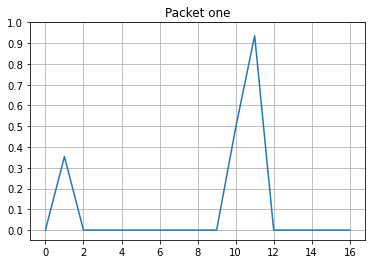

In [1262]:
plt.grid()
plt.plot(np.arange(17), train_data_norm[1])
plt.title("Packet one")
plt.yticks([i/10 for i in range(11)])
plt.show()

In [1312]:
class SparseAnomalyDetector(Model):
    def __init__(self):
        super(SparseAnomalyDetector, self).__init__()
        self.encoder = layers.Dense(17, activation="relu", activity_regularizer=regularizers.l1(10e-5))

        self.decoder = layers.Dense(17, activation="sigmoid")
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = SparseAnomalyDetector()

In [1311]:
autoencoder.layers[0].bias.numpy()

array([0.34907538, 0.8800915 , 0.2990254 , 0.26893416, 0.2865793 ,
       0.7603314 , 0.35714713, 0.21954216, 0.6403666 , 0.24298671,
       0.5293833 , 0.27537555, 0.        , 0.5848382 , 0.52706176,
       0.347277  , 0.2534422 ], dtype=float32)

In [1313]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#Strop training when overfitting is detected
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                  patience=5, 
                                                  min_delta=0.001, 
                                                  mode='auto', 
                                                  verbose=2, 
                                                  baseline=None, 
                                                  restore_best_weights=True)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,profile_batch=0,update_freq='epoch',histogram_freq=1)


In [1314]:
history = autoencoder.fit(train_data_norm, train_data_norm,
          epochs=200, 
          batch_size=256,
          validation_data=(test_data_norm, test_data_norm),
          shuffle=True,
          callbacks=[early_stopping, tensorboard_callback])

Epoch 1/200
70/70 [==============================] - 2s 10ms/step - loss: 0.6265 - accuracy: 0.2252 - val_loss: 0.5453 - val_accuracy: 0.9335
Epoch 2/200
70/70 [==============================] - 0s 5ms/step - loss: 0.4383 - accuracy: 0.9331 - val_loss: 0.3266 - val_accuracy: 0.8965
Epoch 3/200
70/70 [==============================] - 0s 5ms/step - loss: 0.2548 - accuracy: 0.8994 - val_loss: 0.1994 - val_accuracy: 0.9032
Epoch 4/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1735 - accuracy: 0.9127 - val_loss: 0.1532 - val_accuracy: 0.9120
Epoch 5/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1432 - accuracy: 0.9192 - val_loss: 0.1343 - val_accuracy: 0.9203
Epoch 6/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1295 - accuracy: 0.9246 - val_loss: 0.1248 - val_accuracy: 0.9261
Epoch 7/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1220 - accuracy: 0.9292 - val_loss: 0.1191 - val_accuracy: 0.9263
Epoch 8/200


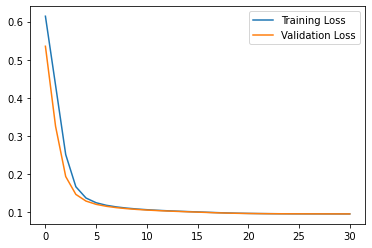

In [1268]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.savefig('Training_Loss.png')

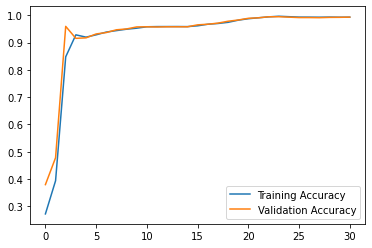

In [1269]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.savefig("Training Accuracy.png")

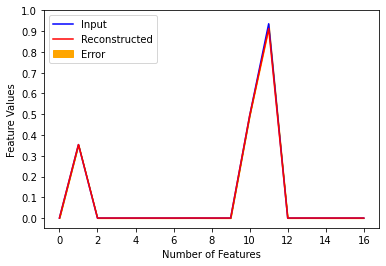

In [1316]:
encoded_data = autoencoder.encoder(test_data_norm).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(test_data_norm[156], 'b')
plt.plot(decoded_data[156], 'r')
plt.fill_between(np.arange(17), decoded_data[131], test_data_norm[131], color='orange')
plt.legend(labels=["Input", "Reconstructed", "Error"])
plt.ylabel('Feature Values')
plt.xlabel('Number of Features')
plt.yticks([i/10 for i in range(11)])
plt.savefig("rec_0.png")
plt.show()

In [1271]:
autoencoder.summary()

Model: "sparse_anomaly_detector_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            multiple                  306       
                                                                 
 dense_55 (Dense)            multiple                  306       
                                                                 
Total params: 612
Trainable params: 612
Non-trainable params: 0
_________________________________________________________________


In [1272]:
#tf.saved_model.save(autoencoder, 'tensormodel/1')

In [1273]:
#%tensorboard --logdir logs

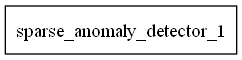

In [1274]:
plot_model(
    autoencoder, 
    to_file='autoencoder_model1.png', 
    show_shapes=True, 
    show_layer_names=True, 
    rankdir='TB' # TB for top to bottom, LR for left to right
)

Image(filename='autoencoder_model1.png')

559/559 [==============================] - 1s 1ms/step


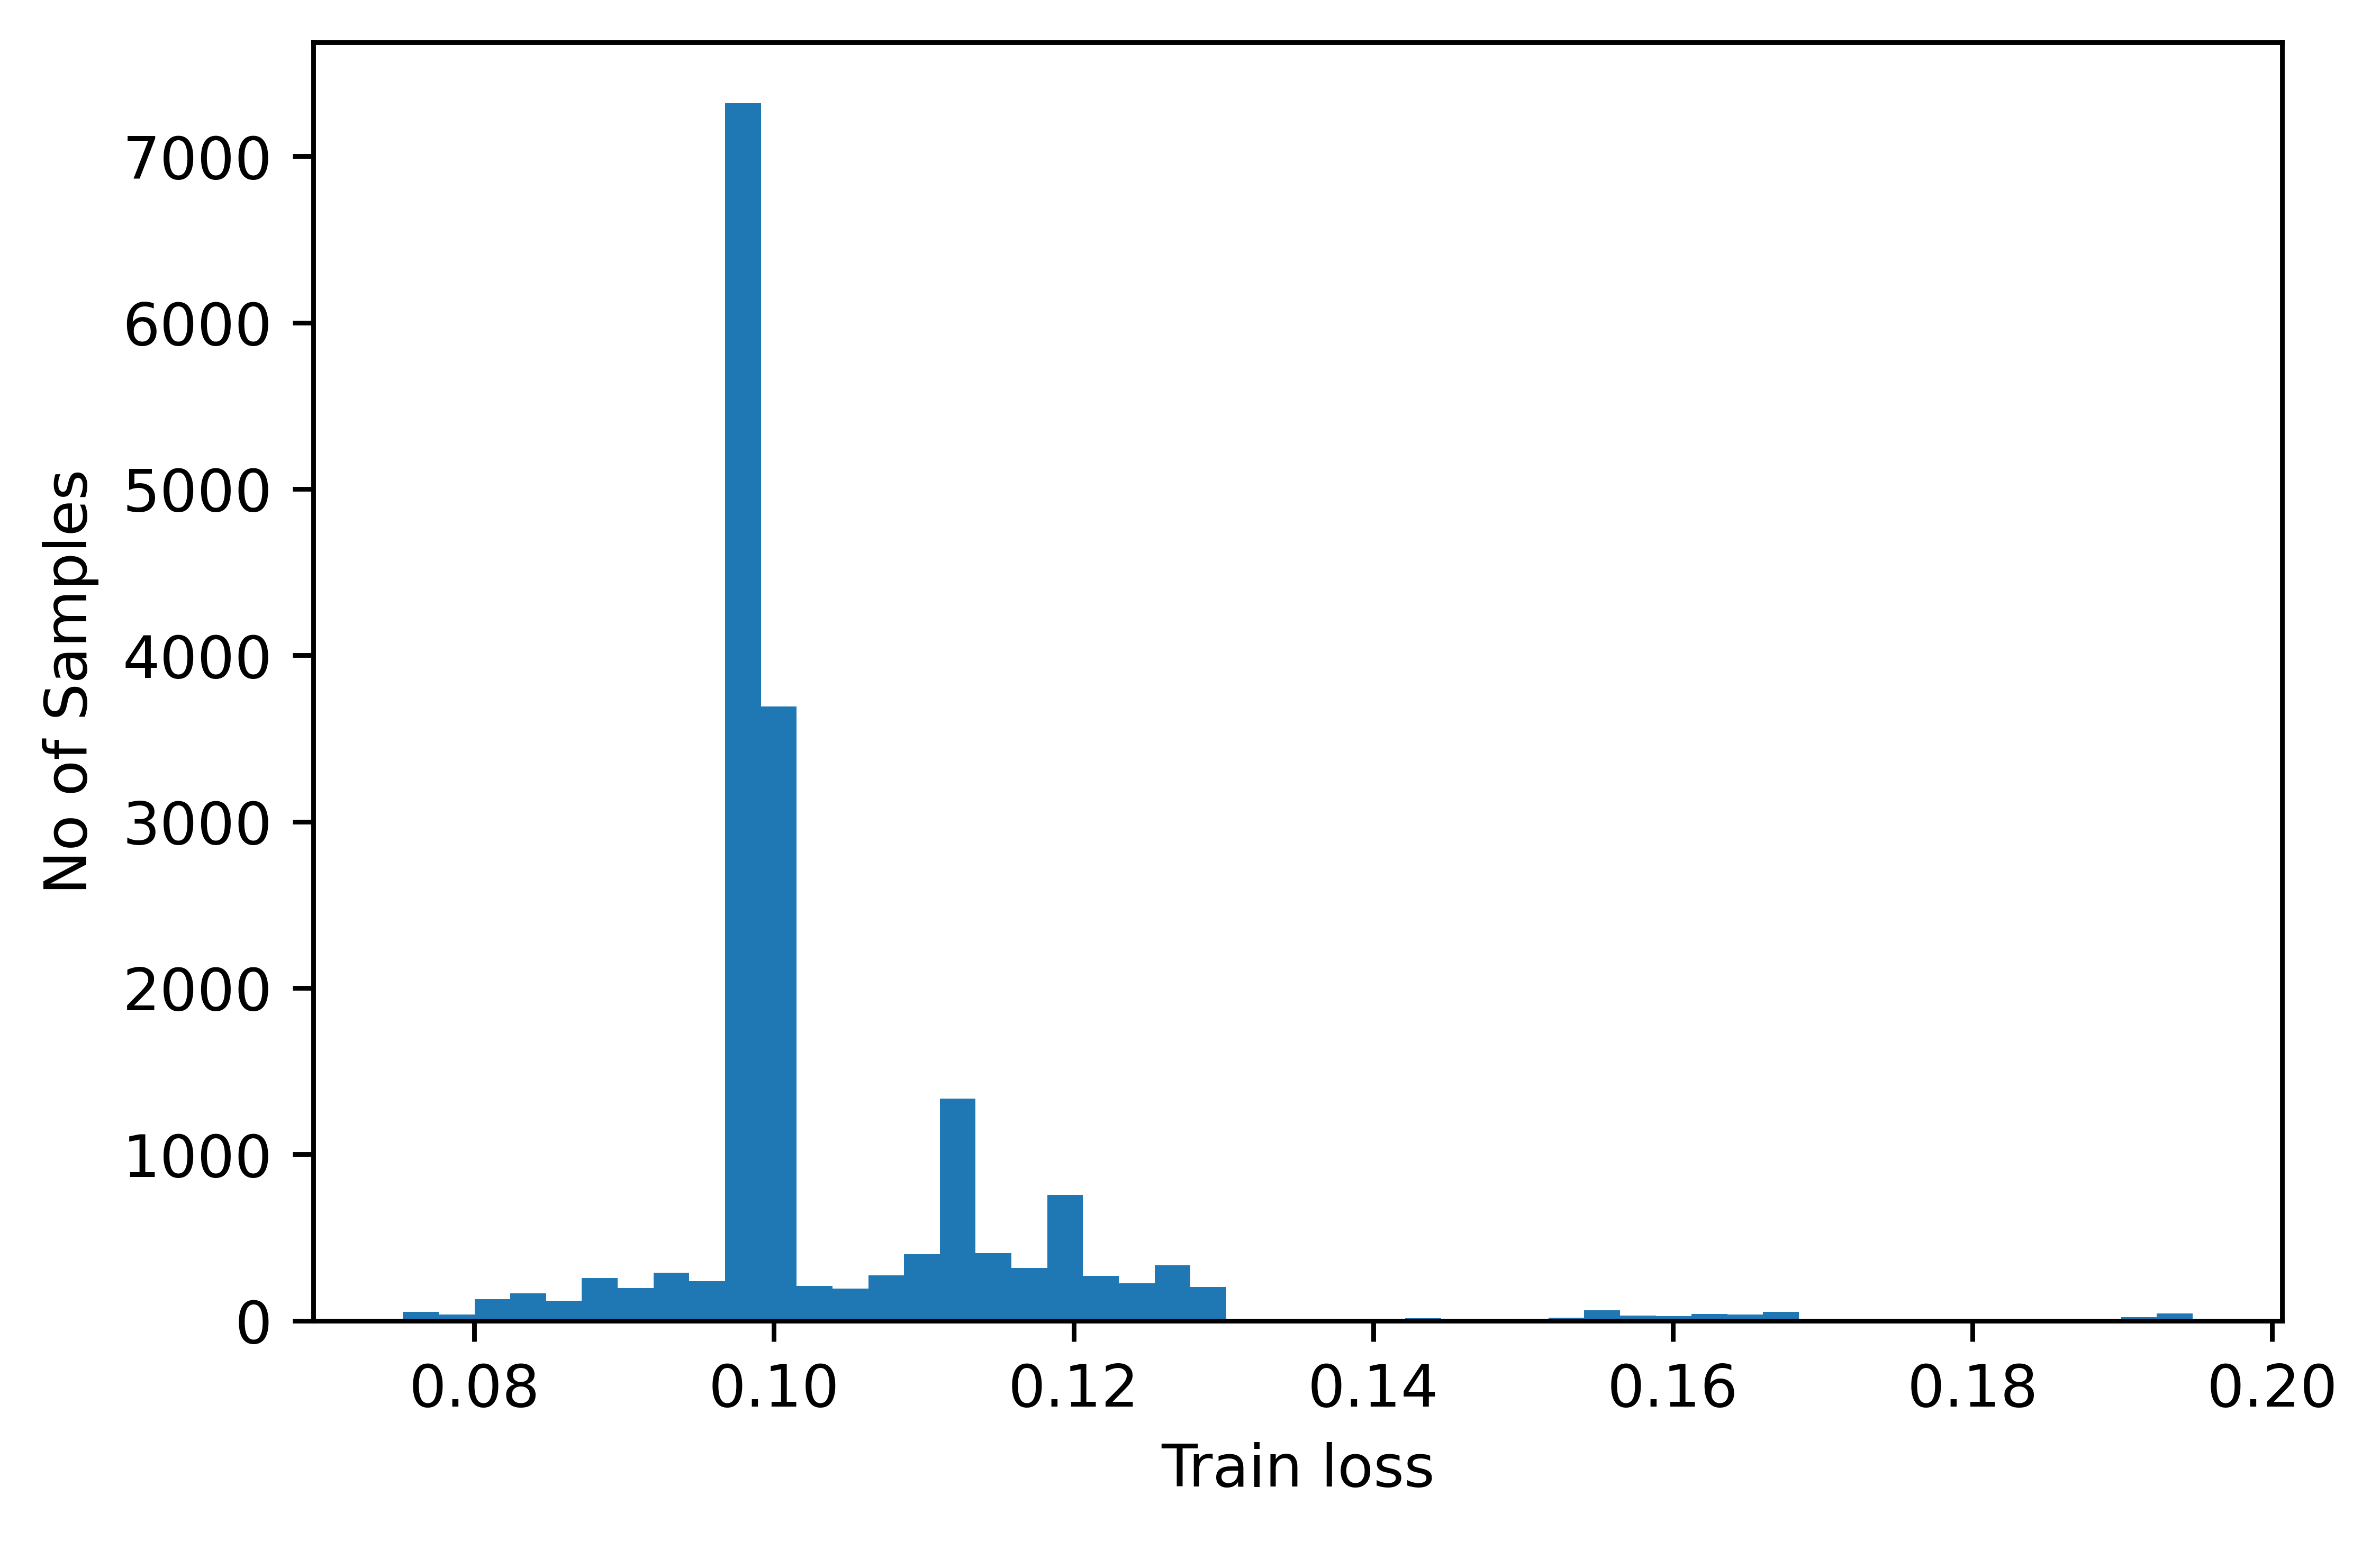

In [1275]:
reconstructions = autoencoder.predict(train_data_norm)
train_loss = tf.keras.losses.binary_crossentropy(reconstructions, train_data_norm)

fig, axe = plt.subplots(dpi=800)

n, bins, _ = axe.hist(train_loss[None,:], bins=50)

plt.xlabel("Train loss")
plt.ylabel("No of Samples")
plt.savefig("Training Loss Distribution.png")
plt.show()

C:\Users\Kasutaja\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


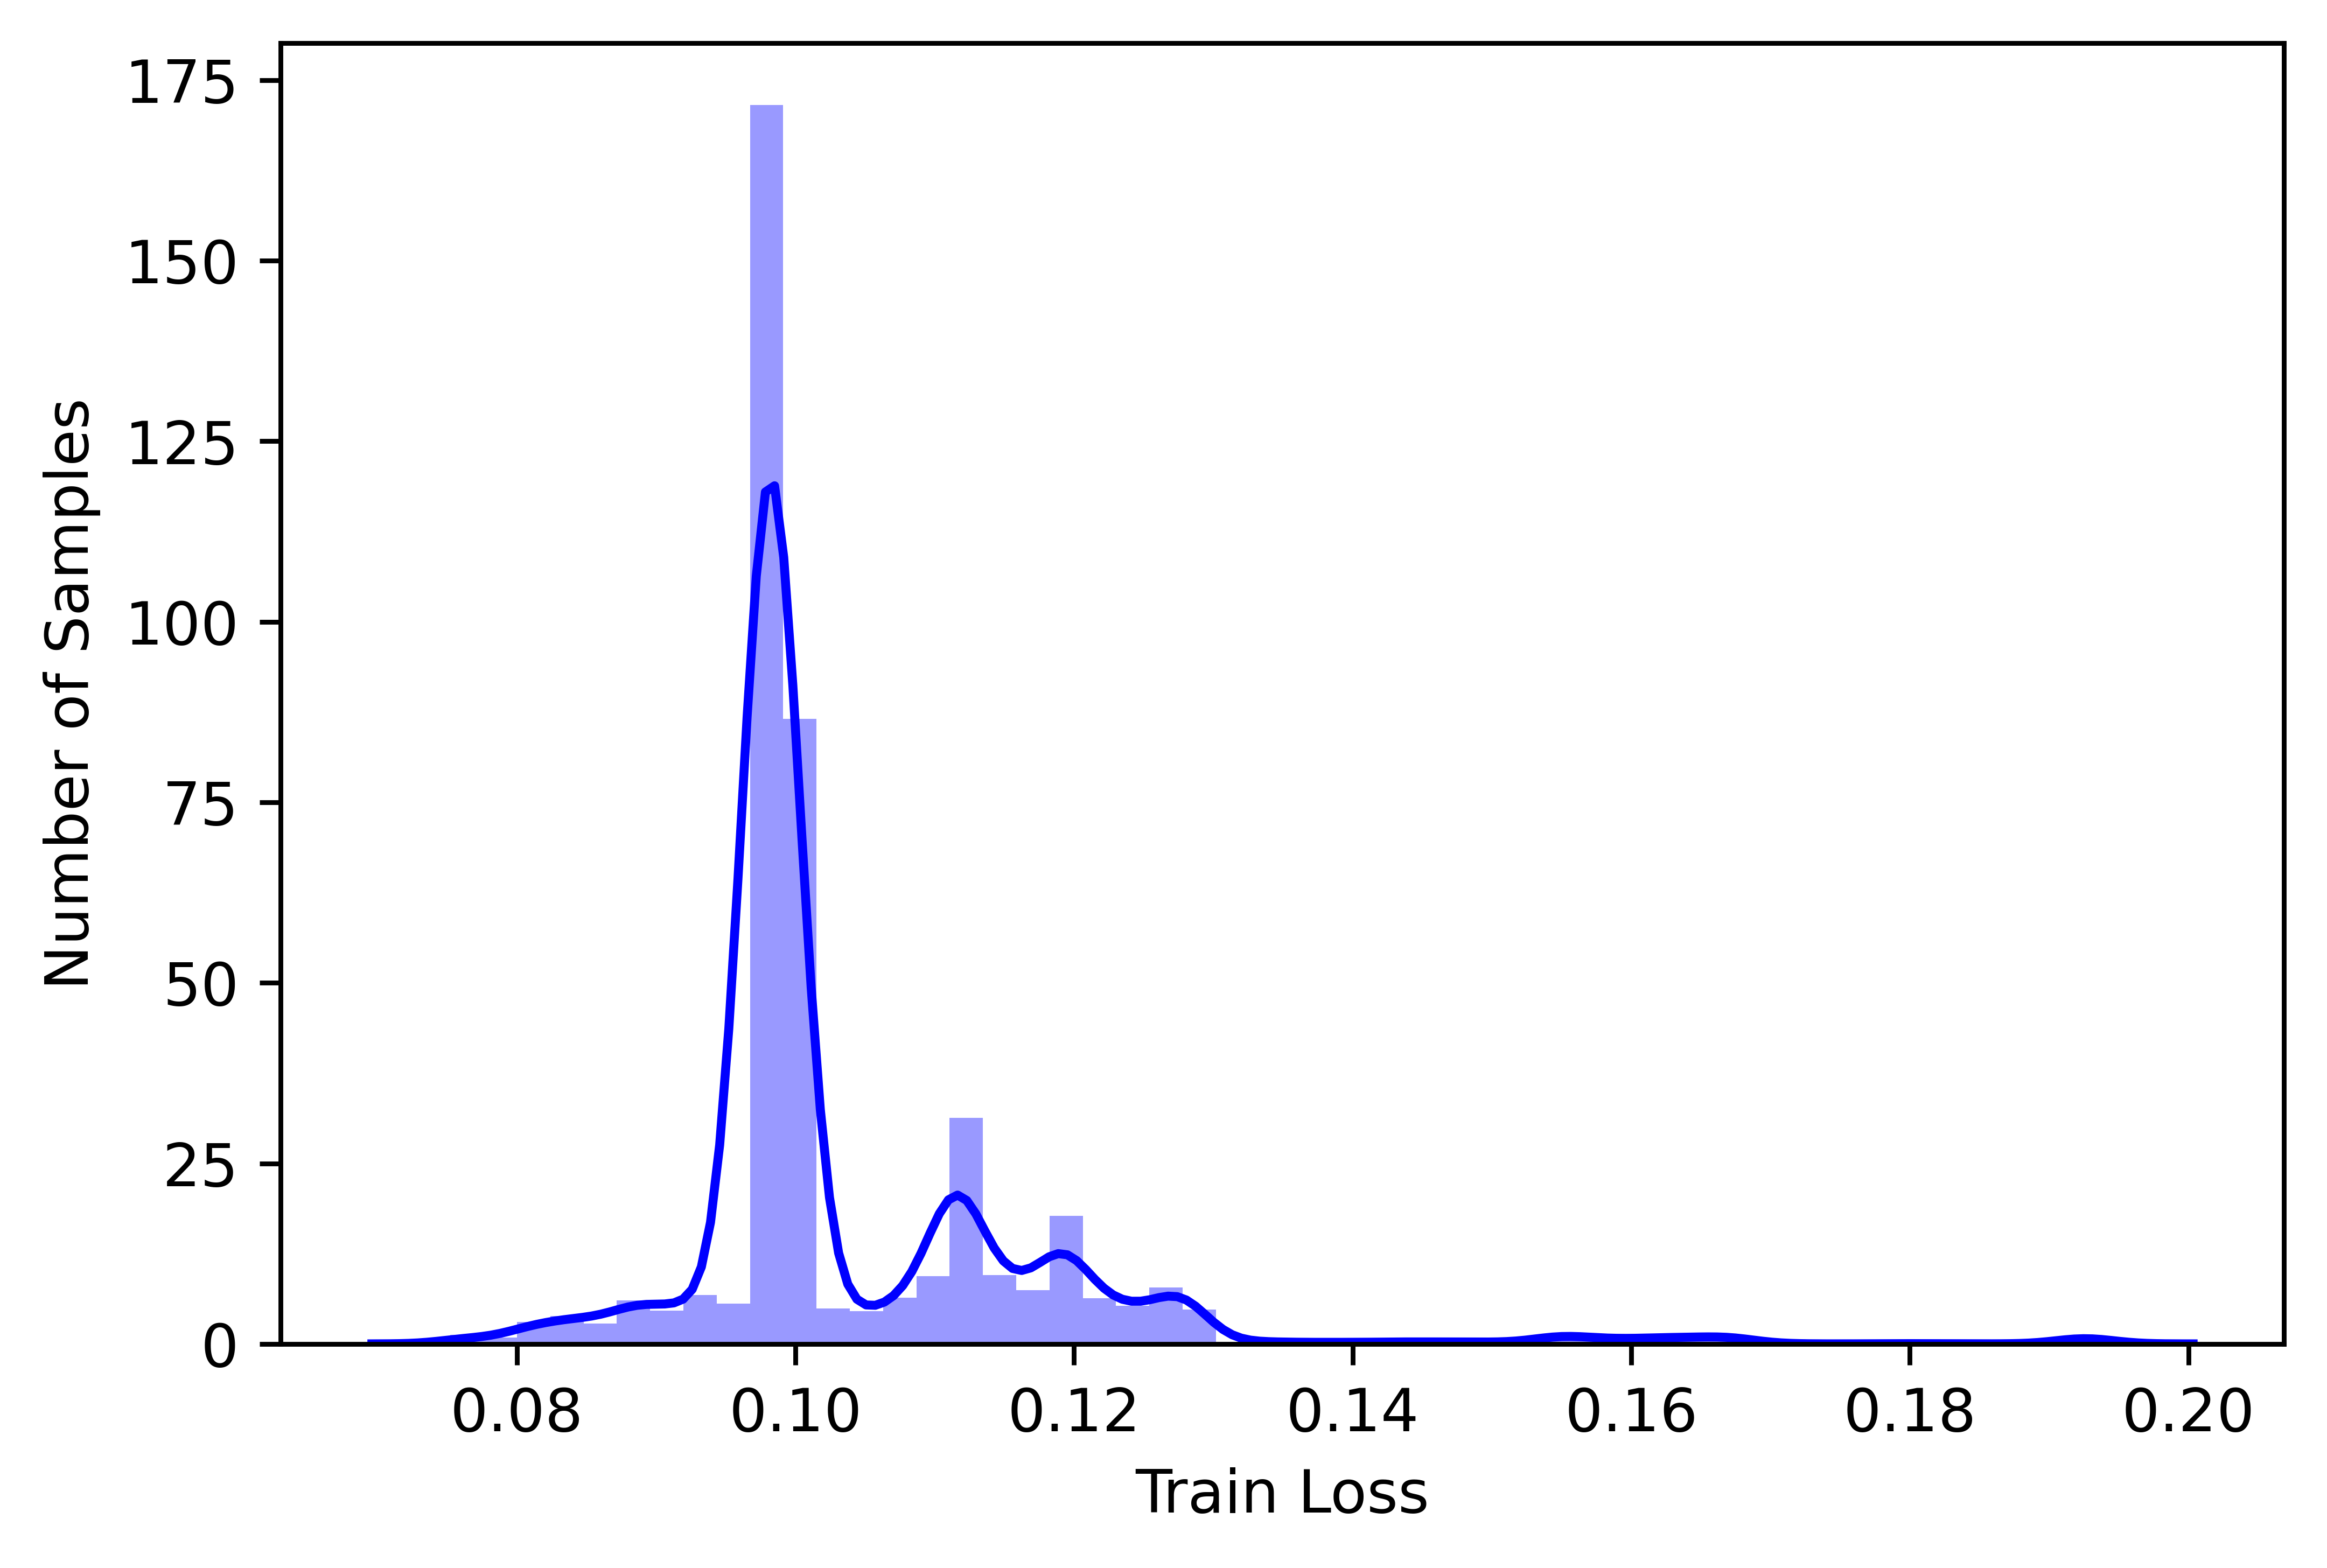

In [1276]:
# Plot the histogram using seaborn
plt.subplots(dpi=800)

dist_sns = sns.distplot(train_loss[None,:], color="b")

plt.xlabel("Train Loss")
plt.ylabel("Number of Samples")
plt.savefig("sns_distri.png")


In [1277]:
#threshold = np.mean(train_loss) + np.std(train_loss)
# Compute the median and MAD of the reconstruction error
b = 1.4826
median = np.median(train_loss)
mad = b * np.median(np.abs(train_loss - median))

# Set the threshold based on the median and MAD
k = 3
threshold = median + k * mad

print("Threshold: ", threshold) 

Threshold:  0.10728149658739566


559/559 [==============================] - 1s 1ms/step


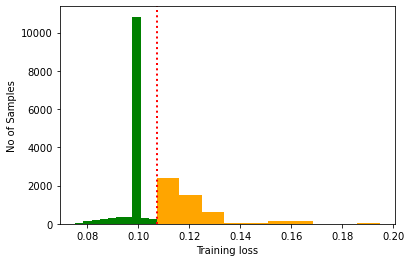

In [1278]:
reconstructions = autoencoder.predict(train_data_norm)
train_loss = tf.keras.losses.binary_crossentropy(reconstructions, train_data_norm)

a=np.array(train_loss[None,:] )

anomaly = a[a >= threshold]
normal =  a[a < threshold]

plt.hist(normal, color='g')
plt.hist(anomaly, color='orange')
plt.xlabel("Training loss")
plt.ylabel("No of Samples")

plt.axvline(threshold, color='red', linestyle='dotted', linewidth=2)
plt.savefig("Anomaly Sample.png")
plt.show()

In [1279]:
reconstructions = autoencoder.predict(test_data_norm)
test_loss = tf.keras.losses.binary_crossentropy(reconstructions, test_data_norm)

a=np.array(test_loss[None,:])

140/140 [==============================] - 0s 973us/step


In [1280]:
a[a < threshold]

array([0.09771481, 0.09945931, 0.09947833, ..., 0.09949719, 0.09775933,
       0.09945802], dtype=float32)

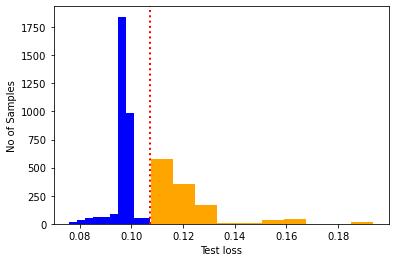

In [1281]:


anomaly = a[a >= threshold]
#equal = a[a == threshold]
normal =  a[a < threshold]

plt.hist(normal, color='b')
plt.hist(anomaly, color='orange')
plt.xlabel("Test loss")
plt.ylabel("No of Samples")

plt.axvline(threshold, color='red', linestyle='dotted', linewidth=2)
plt.savefig("Test Anomaly Sample.png")
plt.show()


In [1282]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.binary_crossentropy(reconstructions, data)
    return reconstructions, loss, tf.math.less(loss, threshold) #Returns the truth value of (loss < threshold) element-wise.

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [1283]:
model, rec_loss, pred_ = predict(autoencoder, test_data_norm, threshold)


### Reconstruction score is the mean of reconstruction eror

In [1284]:
reconstruction_score = np.mean(rec_loss)
print(reconstruction_score)

0.10381517


In [1285]:
pred_

<tf.Tensor: shape=(4465,), dtype=bool, numpy=array([ True,  True,  True, ...,  True,  True, False])>

#### Number of anomalous data

In [1286]:
anomaly_shape=tf.math.count_nonzero(pred_)
anomaly_shape

<tf.Tensor: shape=(), dtype=int64, numpy=3256>

In [1287]:
normal_shape=pred_.shape - anomaly_shape
normal_shape

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1209], dtype=int64)>

C:\Users\Kasutaja\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Kasutaja\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


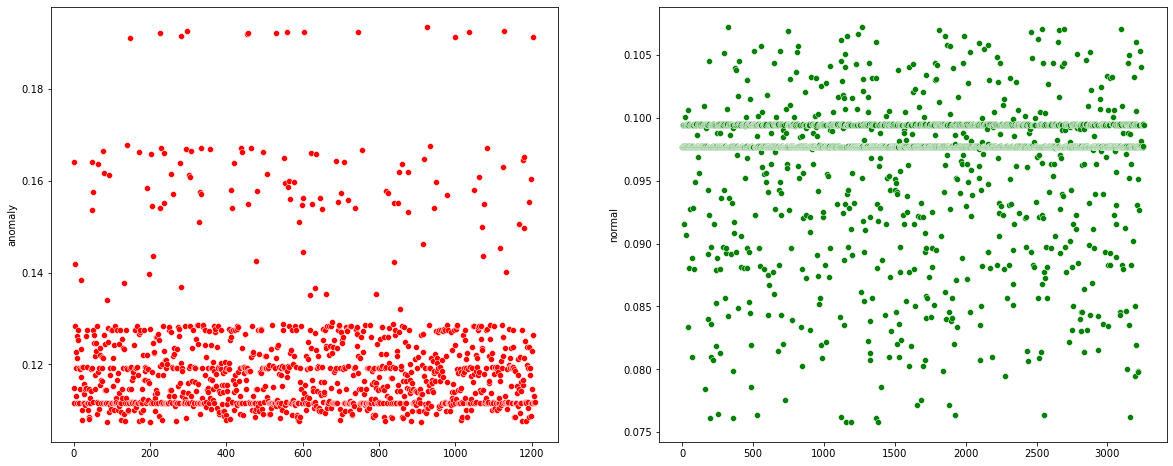

In [1297]:
#sns.scatterplot(data=pred_, hue="time")
anomaly_pd = pd.DataFrame({'anomaly':anomaly})
#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
normal_pd = pd.DataFrame({'normal': normal})

#am_plt=plt.scatter(anomaly_pd.index, anomaly_pd['anom'], color='r')
#plt.show()

#nm_plt=plt.scatter(normal_pd.index, normal_pd['norm'], color='g')
#plt.show

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.scatterplot(anomaly_pd.index, anomaly_pd['anomaly'], y="Anomaly", x='Index', color='red', ax=ax1)
sns.scatterplot(normal_pd.index, normal_pd['normal'], x='Index', color='green', ax=ax2)
plt.savefig('scatterplot.png')
plt.show()

In [1289]:
normal_pd.tail

<bound method NDFrame.tail of         normal
0     0.097715
1     0.099459
2     0.099478
3     0.097747
4     0.097737
...        ...
3251  0.099461
3252  0.099496
3253  0.099497
3254  0.097759
3255  0.099458

[3256 rows x 1 columns]>

In [ ]:
## fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
#sns.heatmap(anomaly_pd, ax=ax1)
#sns.heatmap(normal_pd,  ax=ax2)
#plt.savefig('heatmap.png')
#plt.show()



In [1291]:
#!pip install matplotlib_venn

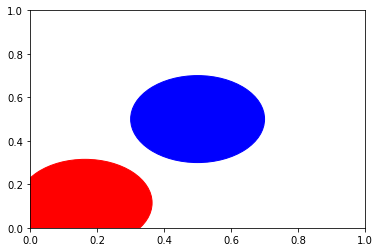

In [1292]:
circle1 = plt.Circle(anomaly, 0.2, color='r')
circle2 = plt.Circle((0.5, 0.5), 0.2, color='green')
circle3 = plt.Circle((1, 1), 0.2, color='g', clip_on=False)

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

ax.add_patch(circle1)
ax.add_patch(circle2)

### Added label to the test data

In [1293]:
x_test_df = pd.DataFrame(np.array(pred_).tolist())

test_data["Label"] = np.array(pred_).tolist()

In [1294]:
test_data

,Index,Time,Identifier,Src_IP,Src_MAC,Dest_IP,Dest_MAC,Src_Port,Dest_Port,Proto,Seq_Num,Ack_Num,TCP_Flag,Window_Size,TCP_Checksum,Packet_Length,Payload,Label
16727,16727,1.518613e+09,27218,29,1,1,1,80.0,49550.0,16727,2.120605e+09,4.015752e+09,0.0,1022.0,14781.0,1500.0,1.759091,True
15337,15337,1.518613e+09,19081,0,0,27,0,49550.0,80.0,15337,4.015752e+09,2.119166e+09,0.0,4809.0,64999.0,40.0,1.585054,True
9505,9505,1.518613e+09,17299,0,0,27,0,49550.0,80.0,9505,4.015751e+09,2.113260e+09,0.0,4860.0,64999.0,40.0,1.585054,True
10957,10957,1.518613e+09,23156,29,1,1,1,80.0,49550.0,10957,2.114679e+09,4.015751e+09,0.0,1023.0,5678.0,1500.0,1.759091,True
7417,7417,1.518613e+09,20866,29,1,1,1,80.0,49550.0,7417,2.111433e+09,4.015751e+09,0.0,1025.0,14067.0,1500.0,1.759091,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6626,6626,1.518613e+09,16105,0,0,27,0,49550.0,80.0,6626,4.015751e+09,2.110522e+09,0.0,3695.0,65011.0,52.0,1.585054,True
3974,3974,1.518612e+09,19159,20,1,1,1,443.0,49524.0,3974,8.065722e+08,4.532528e+08,0.0,513.0,13685.0,1500.0,1.769231,False
15102,15102,1.518613e+09,26072,29,1,1,1,80.0,49550.0,15102,2.118932e+09,4.015752e+09,0.0,1022.0,2083.0,1500.0,1.759091,True
17807,17807,1.518613e+09,19802,0,0,27,0,49550.0,80.0,17807,4.015752e+09,2.121719e+09,0.0,3993.0,64999.0,40.0,1.585054,True


In [1295]:
test_data.to_csv("Detected_Anomaly.csv")